## 0.  필요한 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## 1. 데이터 준비

In [2]:
air_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_reserve.csv')
air_store_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv')
air_visit_data = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv')
hpg_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv')
store_id_relation = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv')
date_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/date_info.csv')
sample_submission = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv')

In [3]:
# preprocessing AIR visitors data
air_data = pd.merge(air_visit_data,air_store_info,how='left', on=['air_store_id']) # merging dataframes
date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)  # renaming columns
air_data = pd.merge(air_data,date_info,how='left', on=['visit_date'])
air_data.sort_values(by='visit_date',ignore_index=True,inplace=True)
air_data['visit_date'] = pd.to_datetime(air_data['visit_date'])
air_data['day'] = air_data['visit_date'].dt.day
air_data['dow'] = air_data['visit_date'].dt.weekday
air_data['year'] = air_data['visit_date'].dt.year
air_data['month'] = air_data['visit_date'].dt.month
air_data['week'] = air_data['visit_date'].dt.week
air_data['quarter'] = air_data['visit_date'].dt.quarter
air_data['visit_date'] = air_data['visit_date'].dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# preprocessing AIR reservation data
air_reserve_data = pd.merge(air_reserve,air_store_info,how='left', on=['air_store_id'])
air_reserve_data.head()
air_reserve_data['visit_datetime'] = pd.to_datetime(air_reserve_data['visit_datetime'])
air_reserve_data['visit_hour'] = air_reserve_data['visit_datetime'].dt.hour
air_reserve_data['visit_date'] = air_reserve_data['visit_datetime'].dt.date
air_reserve_data['reserve_datetime'] = pd.to_datetime(air_reserve_data['reserve_datetime'])
air_reserve_data['reserve_hour'] = air_reserve_data['reserve_datetime'].dt.hour
air_reserve_data['reserve_date'] = air_reserve_data['reserve_datetime'].dt.date
#calculate reservation time difference 
air_reserve_data['res_vis_diff'] = air_reserve_data.apply(
        lambda d: (d['visit_date'] - d['reserve_date']).days, axis=1)
air_reserve_data.rename(columns={'reserve_visitors':'air_reserve_visitors'},inplace=True)
air_reserve_data.to_csv('air_reserve_data.csv',index=False)

In [5]:
# preprocessing HPG reservation data
hpg_reserve_data = pd.merge(hpg_reserve,store_id_relation,on=['hpg_store_id'],how='inner')
hpg_reserve_data = pd.merge(hpg_reserve_data,hpg_store_info,on=['hpg_store_id'],how='left')
hpg_reserve_data['visit_datetime'] = pd.to_datetime(hpg_reserve_data['visit_datetime'])
hpg_reserve_data['visit_hour'] = hpg_reserve_data['visit_datetime'].dt.hour
hpg_reserve_data['visit_date'] = hpg_reserve_data['visit_datetime'].dt.date
hpg_reserve_data['reserve_datetime'] = pd.to_datetime(hpg_reserve_data['reserve_datetime'])
hpg_reserve_data['reserve_hour'] = hpg_reserve_data['reserve_datetime'].dt.hour
hpg_reserve_data['reserve_date'] = hpg_reserve_data['reserve_datetime'].dt.date
#calculate reserve time difference 
hpg_reserve_data['res_vis_diff'] = hpg_reserve_data.apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1)
hpg_reserve_data.rename(columns={'reserve_visitors':'hpg_reserve_visitors'},inplace=True)
hpg_reserve_data.to_csv('hpg_reserve_data.csv',index=False)

In [6]:
# preprocess sample_submission
sample_submission['air_store_id'] = sample_submission['id'].map(lambda x: '_'.join(x.split('_')[:2]))
sample_submission['visit_date'] = sample_submission['id'].map(lambda x: str(x).split('_')[2])
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission['day'] = sample_submission['visit_date'].dt.day
sample_submission['dow'] = sample_submission['visit_date'].dt.weekday
sample_submission['dow_name'] = sample_submission['visit_date'].dt.day_name()
sample_submission['year'] = sample_submission['visit_date'].dt.year
sample_submission['month'] = sample_submission['visit_date'].dt.month
sample_submission['week'] = sample_submission['visit_date'].dt.week
sample_submission['quarter'] = sample_submission['visit_date'].dt.quarter
sample_submission['visit_date'] = sample_submission['visit_date'].dt.date
sample_submission.to_csv('sample_submission.csv',index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
total_air_reserve = air_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['air_reserve_visitors'].sum()
total_hpg_reserve =  hpg_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['hpg_reserve_visitors'].sum()
air_data = pd.merge(air_data,total_air_reserve,on=['air_store_id','visit_date'],how='left')
air_data = pd.merge(air_data,total_hpg_reserve,on=['air_store_id','visit_date'],how='left')
air_data.fillna(value=0,inplace=True)

In [8]:
print("Training dataset overview\n\n")
print("AIR 총 고유 레스토랑 수:",len(air_visit_data.air_store_id.unique()))
print("AIR 및 HPG 공통 총 레스토랑 수:",len(store_id_relation))
print("AIR 레스토랑의 총 고유 장르 수:",len(air_store_info.air_genre_name.unique()))
print("AIR 레스토랑의 총 위치 수",len(air_store_info.air_area_name.unique()))
print("평균 일일 방문자 수:",air_visit_data.visitors.mean())
print("Training data 기간:{} to {}\n\n\n".format(air_visit_data.visit_date.min(),air_visit_data.visit_date.max()))

print("Test dataset overview\n\n")
print("총 고유 레스토랑 수:",len(sample_submission.air_store_id.unique()))
print("Test data 기간:{} to {}".format(sample_submission.visit_date.min(),sample_submission.visit_date.max()))

Training dataset overview


AIR 총 고유 레스토랑 수: 829
AIR 및 HPG 공통 총 레스토랑 수: 150
AIR 레스토랑의 총 고유 장르 수: 14
AIR 레스토랑의 총 위치 수 103
평균 일일 방문자 수: 20.973761245180636
Training data 기간:2016-01-01 to 2017-04-22



Test dataset overview


총 고유 레스토랑 수: 821
Test data 기간:2017-04-23 to 2017-05-31


## 2. 데이터 시각화 및 분석

### 2-1. 레스토랑 당 평균 방문자 수

### 레스토랑 당 평균 방문자 수 확률 밀도 함수(PDF)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


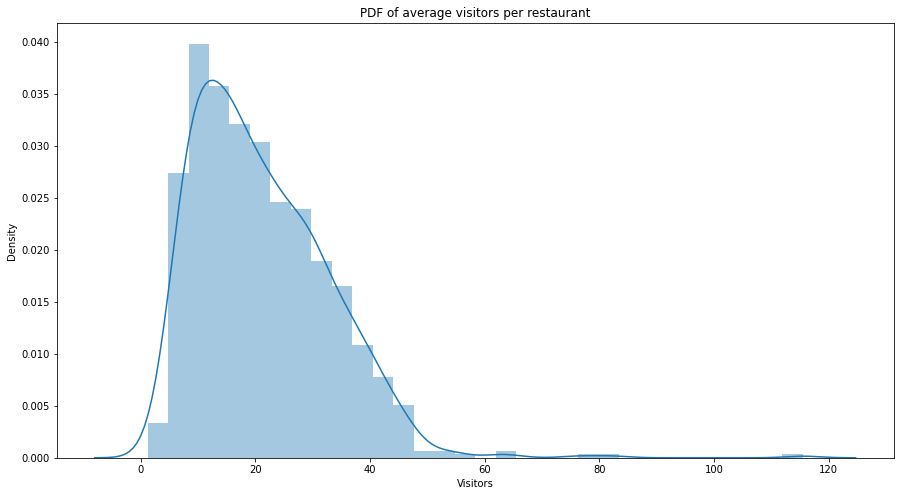

In [9]:
temp = air_data.groupby(['air_store_id'])['visitors'].mean().to_frame()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=temp.visitors.values, ax=ax)
plt.xlabel('Visitors')
plt.ylabel('Density')
plt.title('PDF of average visitors per restaurant')
plt.show()

분석

### 레스토랑 당 평균 방문자 수 누적 분포 함수(CDF)

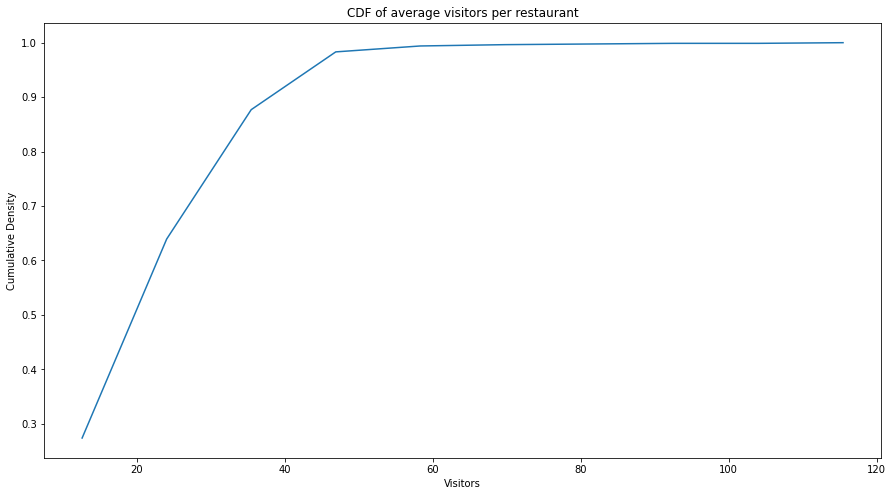

In [10]:
f,ax = plt.subplots(1,1, figsize=(15,8))
counts, bin_edges = np.histogram(temp['visitors'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))#cal pdf
cdf = np.cumsum(pdf)#cumulative sum of pdf,calculating cdf
plt.plot(bin_edges[1:], cdf)
plt.ylabel('Cumulative Density')
plt.xlabel('Visitors')
plt.title('CDF of average visitors per restaurant')
plt.show()

분석-

### 레스토랑 당 평균 방문자 수 Box Plot

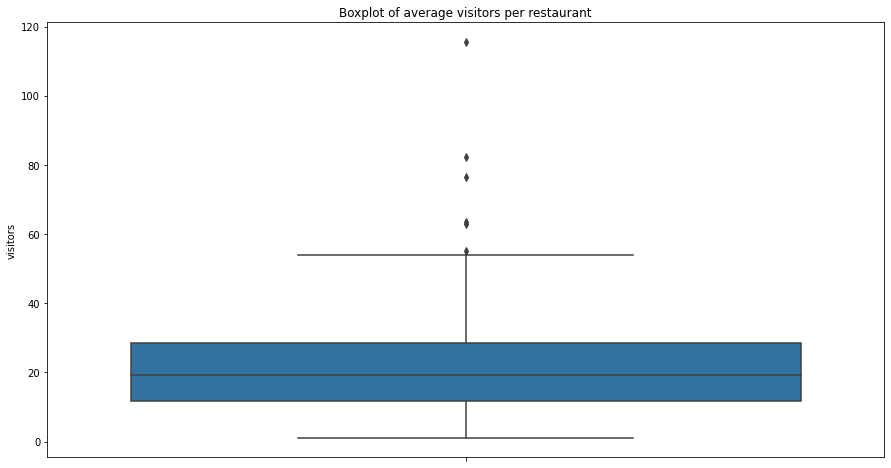

In [11]:
f,ax = plt.subplots(1,1, figsize=(15,8))
sns.boxplot(y='visitors', data=temp,ax=ax)
plt.title('Boxplot of average visitors per restaurant')
plt.show()

### 2-2. 레스토랑 당 평균 예약 수

### 레스토랑 당 평균 예약 수 확률 밀도 함수(PDF)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


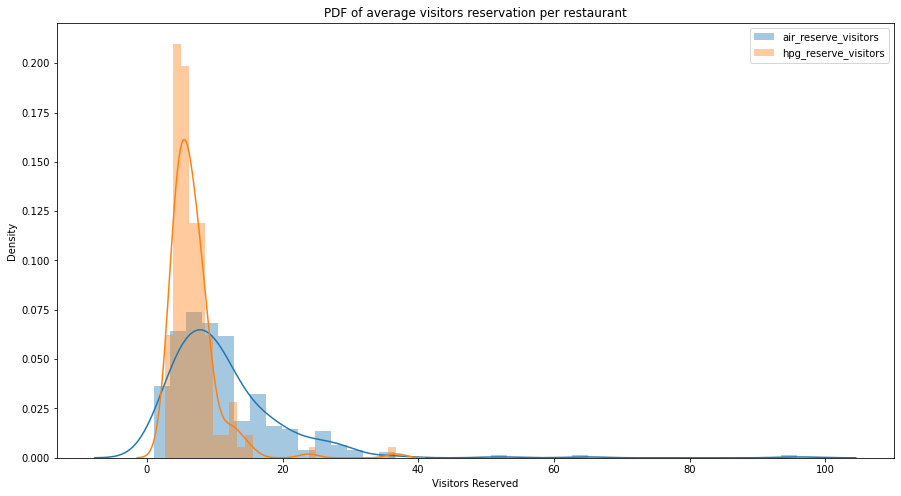

In [12]:
temp_1 = total_air_reserve.groupby(['air_store_id'],as_index=False)['air_reserve_visitors'].mean()
temp_2 = total_hpg_reserve.groupby(['air_store_id'],as_index=False)['hpg_reserve_visitors'].mean()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=temp_1.air_reserve_visitors.values, ax=ax, label='air_reserve_visitors')
sns.distplot(a=temp_2.hpg_reserve_visitors.values, ax=ax, label='hpg_reserve_visitors')
plt.xlabel('Visitors Reserved')
plt.ylabel('Density')
plt.legend()
plt.title('PDF of average visitors reservation per restaurant')
plt.show()

분석

### 레스토랑 당 평균 예약 수 누적 분포 함수(CDF)

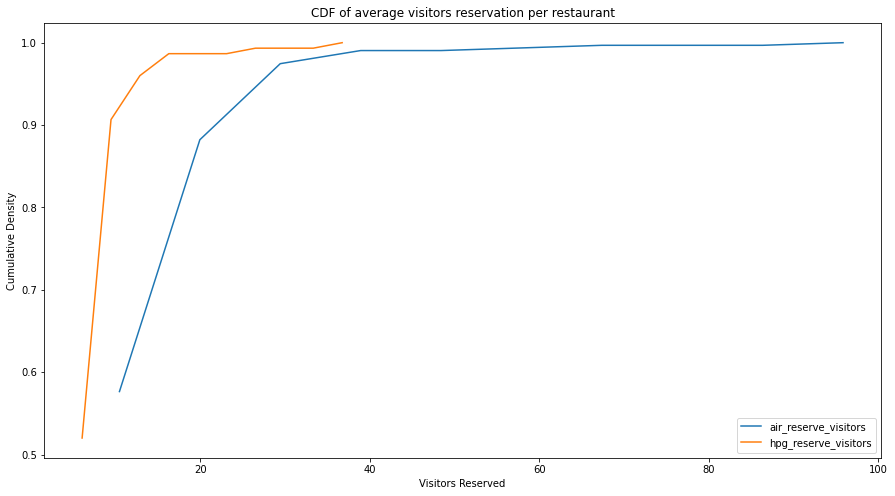

In [13]:
f,ax = plt.subplots(1,1, figsize=(15,8))
counts, bin_edges = np.histogram(temp_1['air_reserve_visitors'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))#cal pdf
cdf = np.cumsum(pdf)#cumulative sum of pdf,calculating cdf
plt.plot(bin_edges[1:], cdf,label='air_reserve_visitors')

counts, bin_edges = np.histogram(temp_2['hpg_reserve_visitors'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))#cal pdf
cdf = np.cumsum(pdf)#cumulative sum of pdf,calculating cdf
plt.plot(bin_edges[1:], cdf,label='hpg_reserve_visitors')
plt.ylabel('Cumulative Density')
plt.xlabel('Visitors Reserved')
plt.legend()
plt.title('CDF of average visitors reservation per restaurant')
plt.show()

분석

### 레스토랑 당 평균 예약 수 Box Plot

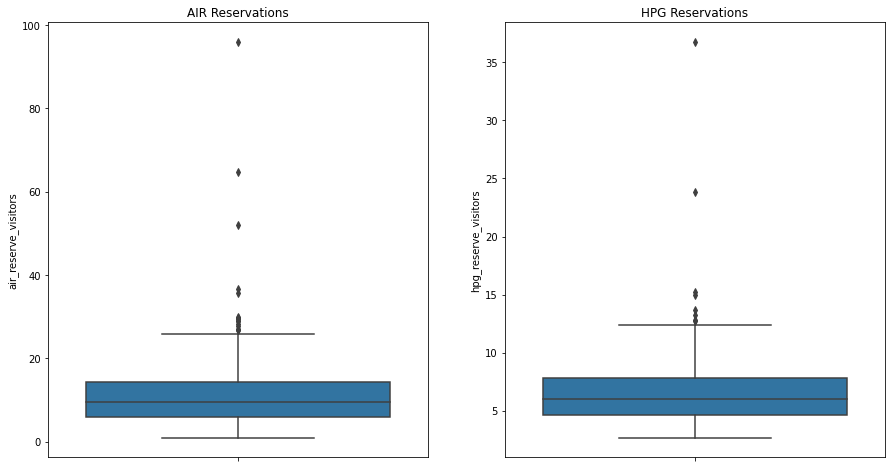

In [14]:
f,ax = plt.subplots(1,2, figsize=(15,8))
sns.boxplot(y='air_reserve_visitors', data=temp_1,ax=ax[0])
plt.title("title")
sns.boxplot(y='hpg_reserve_visitors', data=temp_2,ax=ax[1])
ax[0].set_title('AIR Reservations')
ax[1].set_title('HPG Reservations')
plt.show()

분석

### 2-3. 레스토랑 장르별 시장 점유율

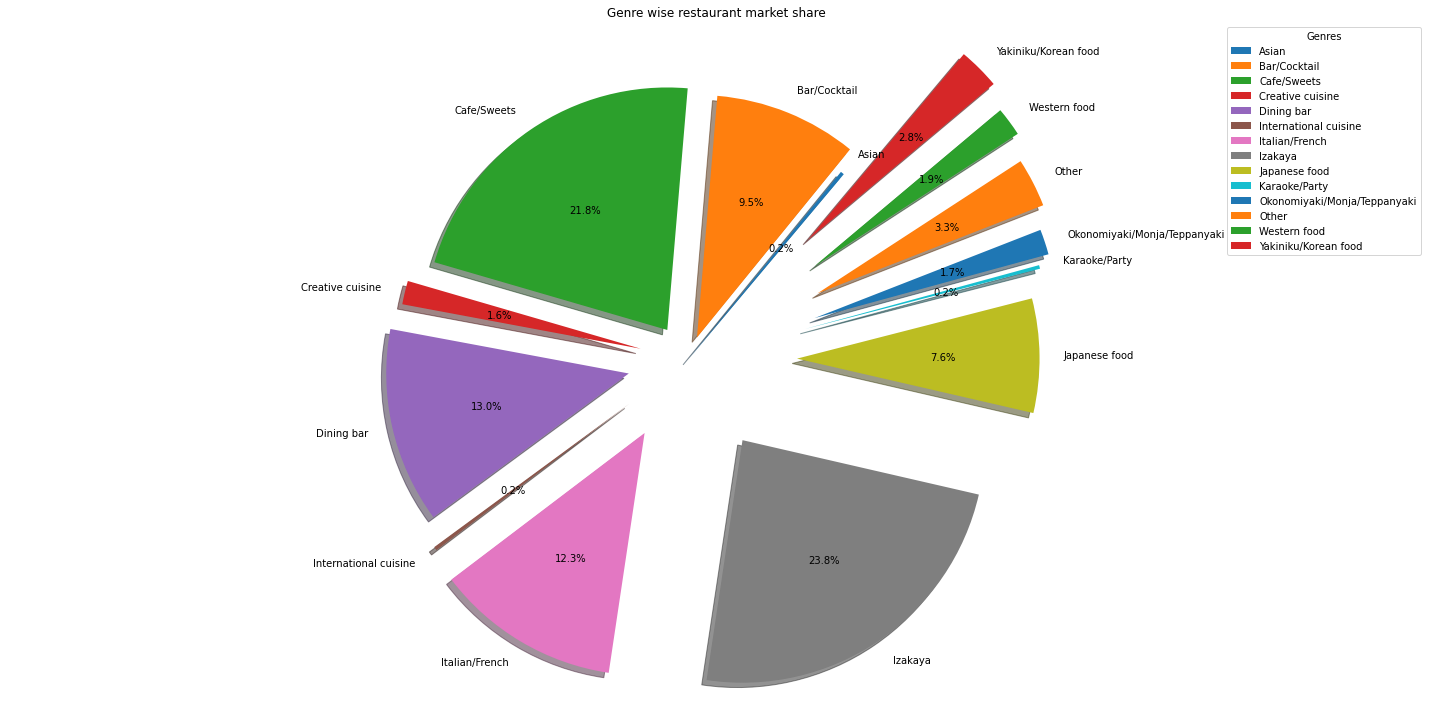

In [15]:
temp = air_store_info.groupby(['air_genre_name'],as_index=False)['air_store_id'].count()
# Pie chart
labels = temp.air_genre_name.values
sizes = temp.air_store_id.values
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7)  
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Genres')
plt.title('Genre wise restaurant market share')
plt.show()

분석

### 2-4. 고유 상점 수

Text(0.5, 1.0, 'Number Unique Store ID')

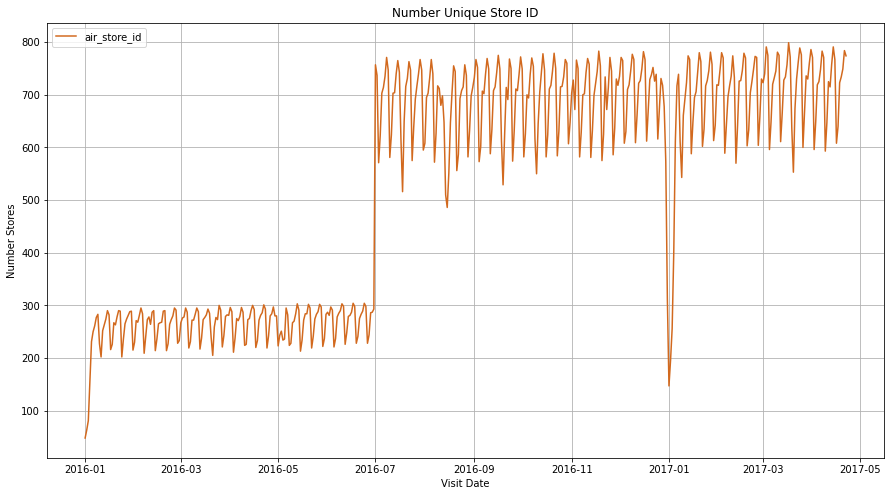

In [16]:
# refernce :- https://www.kaggle.com/faizalabdkadir/recruit-visual-eda-itadakimasu
f,ax = plt.subplots(1,1, figsize=(15,8))
stores= air_data.groupby(['visit_date'])['air_store_id'].size()
stores.plot(kind='line',  color= 'chocolate', grid=True, ax=ax, legend=True)
plt.ylabel("Number Stores")
plt.xlabel("Visit Date")
plt.title("Number Unique Store ID")

분석

### 2-5. 총 방문자 및 예약 수

Text(0.5, 1.0, 'Visitor and Reservations')

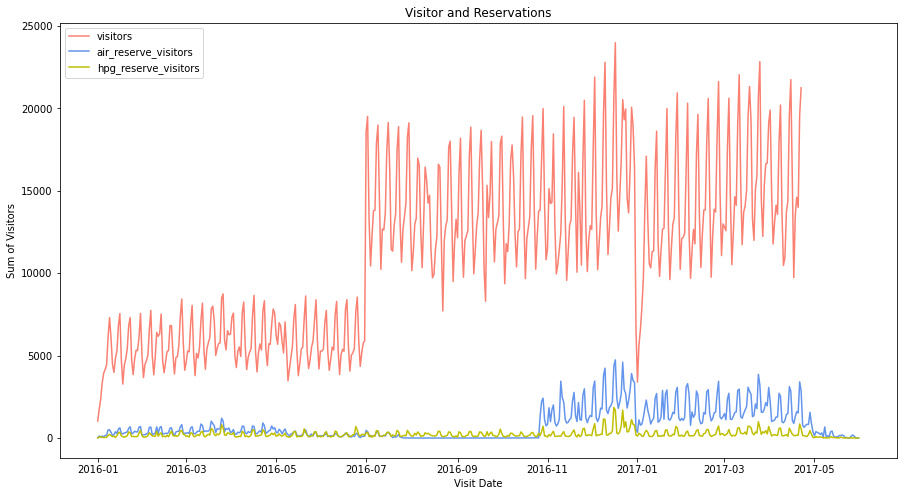

In [17]:
f,ax = plt.subplots(1,1,figsize=(15,8))
plt1 = air_data.groupby(['visit_date'])['visitors'].sum().to_frame()
plt2 = air_reserve_data.groupby(['visit_date'])['air_reserve_visitors'].sum().to_frame()
plt3 = hpg_reserve_data.groupby(['visit_date'])['hpg_reserve_visitors'].sum().to_frame()
plt1.plot(color='salmon', kind='line', ax=ax)
plt2.plot(color='cornflowerblue', kind='line', ax=ax)
plt3.plot(color='y', kind='line', ax=ax)
plt.legend()
plt.ylabel("Sum of Visitors")
plt.xlabel("Visit Date")
plt.title("Visitor and Reservations")

분석

### 2-6. 레스토랑 장르별 총 방문자 수

Text(0.5, 1.0, 'Total visitors by air_genre_name')

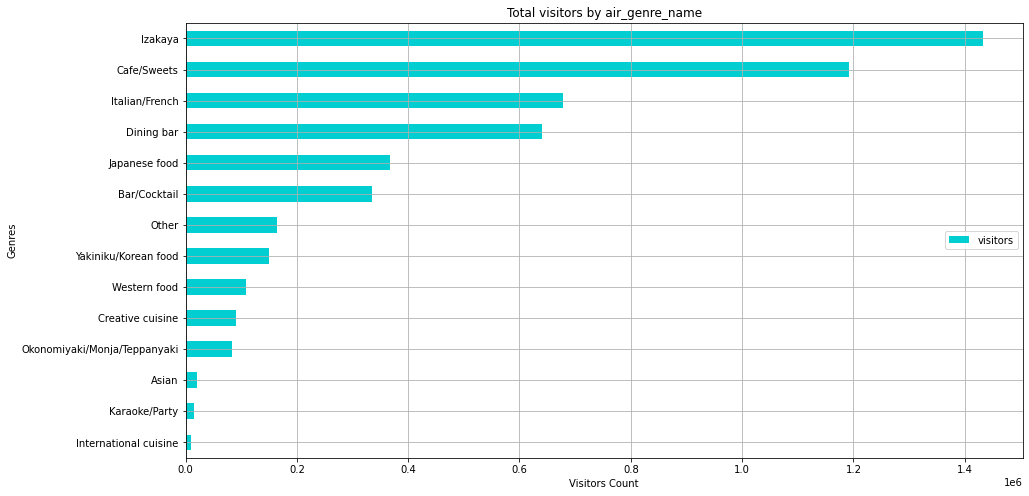

In [18]:
f,ax = plt.subplots(1,1, figsize=(15,8))
genre = air_data.groupby(['air_genre_name'])['visitors'].sum().to_frame()
genre.sort_values(by='visitors',inplace=True)
genre.plot(kind='barh',color= 'darkturquoise', grid=True, ax=ax, legend=True)
plt.ylabel('Genres')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Total visitors by air_genre_name", loc='center')

분석

### 2-7. 레스토랑 장르별 총 예약 방문자 수

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


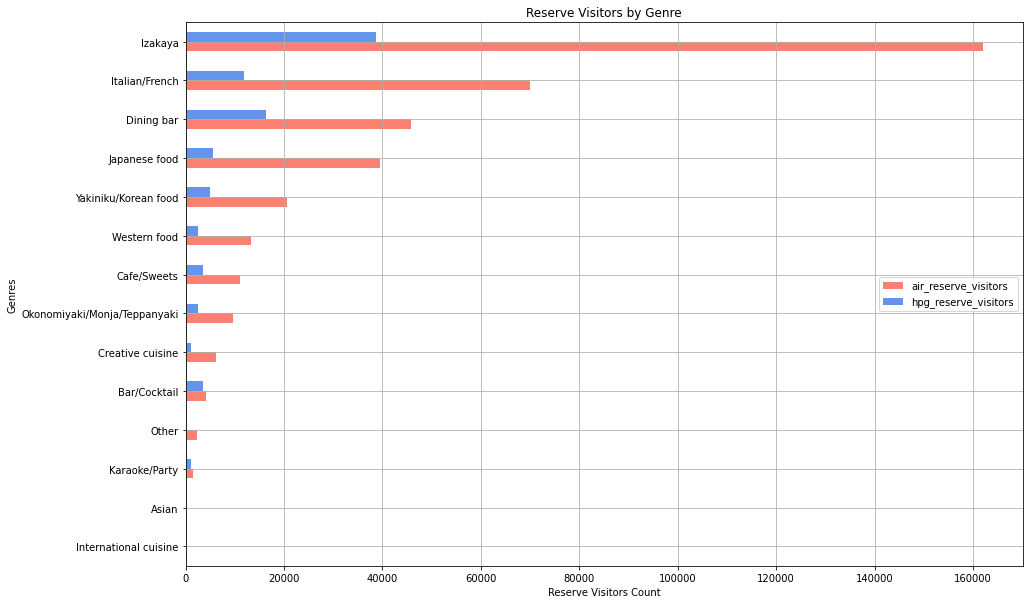

In [19]:
f,ax = plt.subplots(1,1, figsize=(15,10))
genre = air_data.groupby(['air_genre_name'])['air_reserve_visitors','hpg_reserve_visitors'].sum()
genre.sort_values(by=['air_reserve_visitors','hpg_reserve_visitors'],inplace=True)
genre.plot(kind='barh',color= ['salmon','cornflowerblue'], grid=True, ax=ax, legend=True)
plt.ylabel('Genres')
plt.xlabel('Reserve Visitors Count')
plt.legend(loc='center right')
plt.title("Reserve Visitors by Genre", loc='center')
plt.show()

분석

### 2-8. 요일별 연간 방문자 동향

Text(0.5, 1.0, 'Visitors by Day of the Week ')

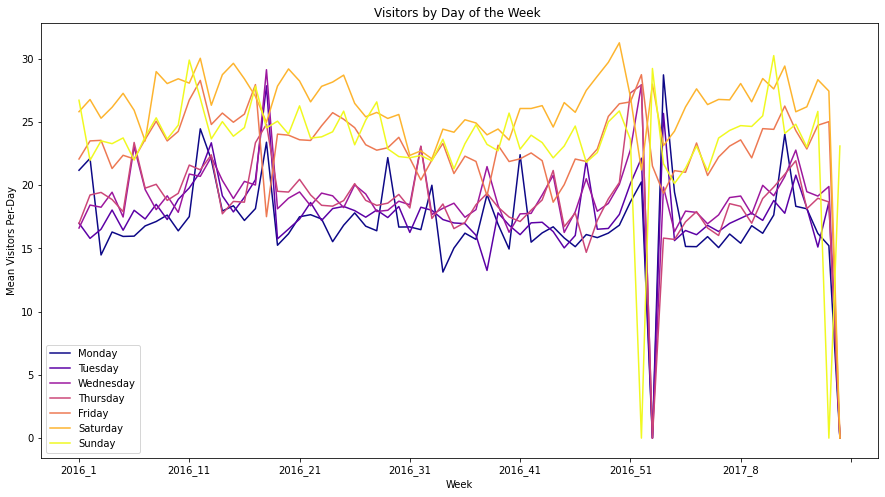

In [20]:
dow=pd.pivot_table(air_data, index=['year','week'], columns='dow',values='visitors',aggfunc=[np.mean],fill_value=0)
dow=pd.DataFrame(dow.to_records())
dow['year_week']=dow['year'].astype(str) +'_'+ dow['week'].astype(str)
dow.index = dow['year_week']
dow.drop(['year','week','year_week'],axis=1,inplace=True)
dow.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

f, ax=plt.subplots(1,1, figsize=(15,8))
dow.plot(kind='line', ax=ax, cmap='plasma')
plt.ylabel("Mean Visitors Per-Day")
plt.xlabel("Week")
plt.title("Visitors by Day of the Week ")

분석

### 2-9. 요일별 평균 방문자 수

Text(0.5, 1.0, 'Average Visitors Each Day Of Week')

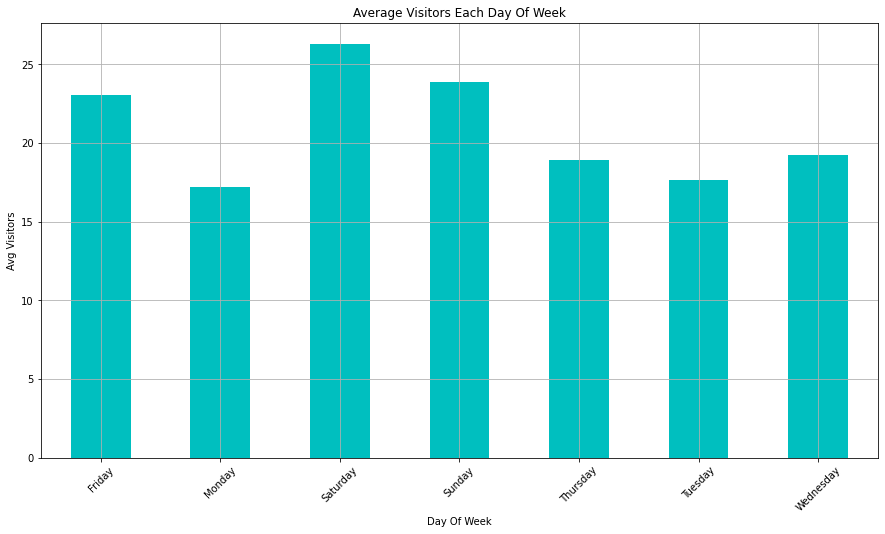

In [21]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['day_of_week'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'c', grid=True, ax=ax, legend=False)
plt.xticks(rotation=45)
plt.xlabel('Day Of Week')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Week')

분석

### 2-10. 일 별 평균 방문자 수

Text(0.5, 1.0, 'Average Visitors Each Day Of Month')

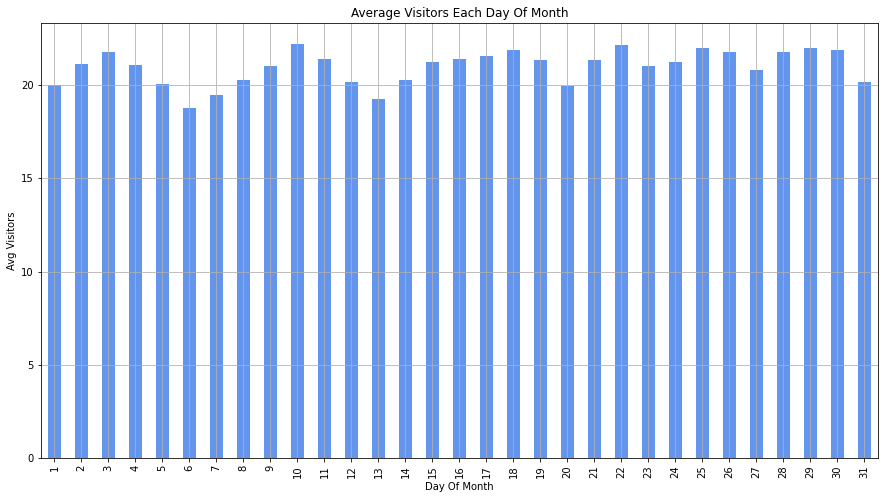

In [22]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['day'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'cornflowerblue', grid=True, ax=ax,legend=False)
plt.xlabel('Day Of Month')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Month')

분석

### 2-11. 월 평균 방문자 수

Text(0.5, 1.0, 'Monthly Average Visitors')

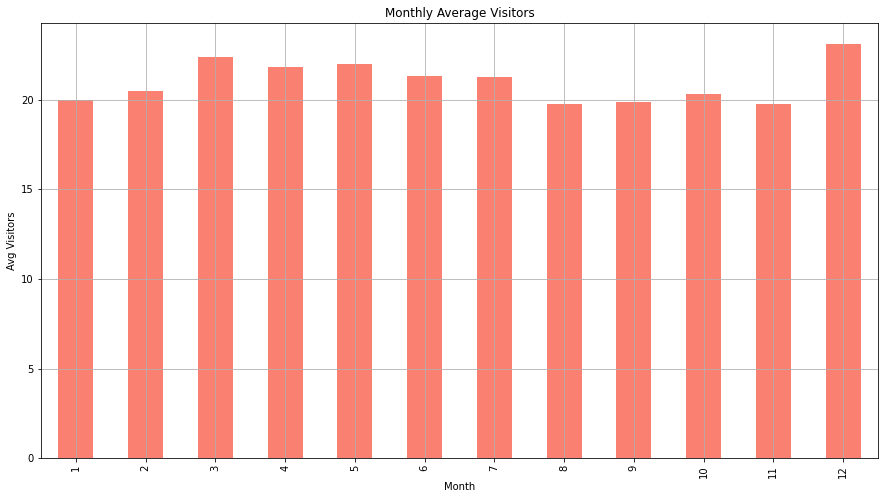

In [23]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['month'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'salmon', grid=True, ax=ax,legend=False)
plt.xlabel('Month')
plt.ylabel('Avg Visitors')
plt.title('Monthly Average Visitors')

분석

### 2-12. 공휴일 및 비공휴일 평균 방문자 수

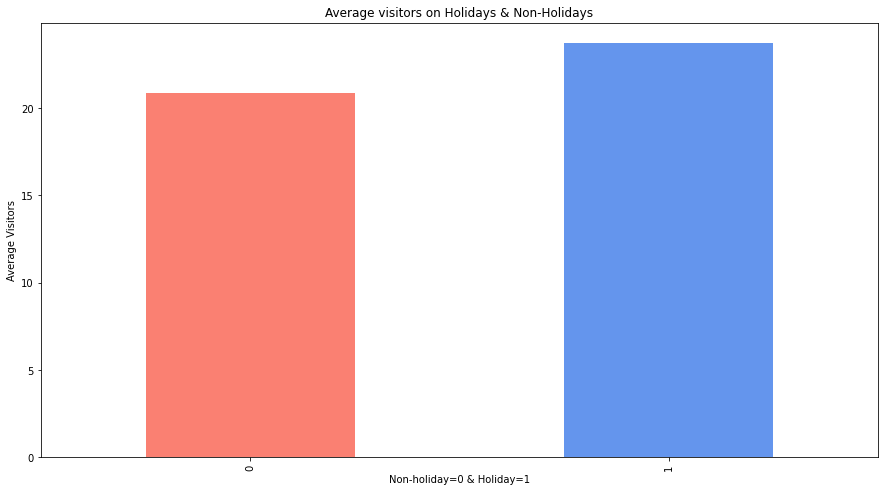

In [24]:
temp = air_data[['holiday_flg','visitors']].groupby(['holiday_flg'])['visitors'].mean()
temp.plot(kind='bar',color= ['salmon','cornflowerblue'],figsize=(15,8))
plt.ylabel('Average Visitors')
plt.xlabel('Non-holiday=0 & Holiday=1')
plt.title('Average visitors on Holidays & Non-Holidays')
plt.show()

분석

----


## Feature Engineering

### Training Set, Validation Set, Test Set 생성

In [25]:
air_data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,day,dow,year,month,week,quarter,air_reserve_visitors,hpg_reserve_visitors
0,air_fab092c35776a9b1,2016-01-01,19,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,Friday,1,1,4,2016,1,53,1,0.0,0.0
1,air_f26f36ec4dc5adb0,2016-01-01,64,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,Friday,1,1,4,2016,1,53,1,0.0,0.0
2,air_d97dabf7aae60da5,2016-01-01,102,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,Friday,1,1,4,2016,1,53,1,0.0,0.0
3,air_39dccf7df20b1c6a,2016-01-01,55,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,Friday,1,1,4,2016,1,53,1,0.0,0.0
4,air_79f528087f49df06,2016-01-01,42,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,Friday,1,1,4,2016,1,53,1,0.0,0.0


`air_data` 에서  `visitors`, `air_genre_name`, `air_area_name`, `latitude`, `longitude`, `holiday_flg`, `day`, `dow`,`year`, `month`, `week`, `quarter` 를 학습을 위한 feature 로 사용한다.  

이때 `visitors` 가 target feature 가 된다.

In [26]:
train = air_data.copy()
train = train.drop(['air_reserve_visitors','hpg_reserve_visitors', 'day_of_week'], axis=1)
train

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_flg,day,dow,year,month,week,quarter
0,air_fab092c35776a9b1,2016-01-01,19,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,1,1,4,2016,1,53,1
1,air_f26f36ec4dc5adb0,2016-01-01,64,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,1,1,4,2016,1,53,1
2,air_d97dabf7aae60da5,2016-01-01,102,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,1,1,4,2016,1,53,1
3,air_39dccf7df20b1c6a,2016-01-01,55,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,1,1,4,2016,1,53,1
4,air_79f528087f49df06,2016-01-01,42,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,1,1,4,2016,1,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_6a15e4eae523189d,2017-04-22,12,Bar/Cocktail,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,22,5,2017,4,16,2
252104,air_bf13014b6e3e60ca,2017-04-22,49,Cafe/Sweets,Tōkyō-to Setagaya-ku Setagaya,35.646572,139.653247,0,22,5,2017,4,16,2
252105,air_c52c63c781fe48f6,2017-04-22,41,Cafe/Sweets,Fukuoka-ken Itoshima-shi Maebarunishi,33.557320,130.195555,0,22,5,2017,4,16,2
252106,air_59cc9b2b209c6331,2017-04-22,12,Cafe/Sweets,Tōkyō-to Setagaya-ku Setagaya,35.646572,139.653247,0,22,5,2017,4,16,2


In [27]:
sample_submission = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv')

In [28]:
test = sample_submission.copy()
test['air_store_id'] = test['id'].apply(lambda x: str(x)[:-11])
test['visit_date'] = test['id'].apply(lambda x: str(x)[-10:])
test = test.drop(['id', 'visitors'], axis = 1)

test = pd.merge(test,air_store_info,how='left', on=['air_store_id'])
#date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)
test = pd.merge(test,date_info,how='left', on=['visit_date'])
test = test.drop(['day_of_week'], axis = 1)     # 'daw' column 과 겹치므로 삭제 


test['visit_date'] = pd.to_datetime(test['visit_date'])
test['day'] = test['visit_date'].dt.day
test['dow'] = test['visit_date'].dt.weekday
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['week'] = test['visit_date'].dt.week
test['quarter'] = test['visit_date'].dt.quarter
test['visit_date'] = test['visit_date'].dt.date
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,holiday_flg,day,dow,year,month,week,quarter
0,air_00a91d42b08b08d9,2017-04-23,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,23,6,2017,4,16,2
1,air_00a91d42b08b08d9,2017-04-24,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,24,0,2017,4,17,2
2,air_00a91d42b08b08d9,2017-04-25,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,25,1,2017,4,17,2
3,air_00a91d42b08b08d9,2017-04-26,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,26,2,2017,4,17,2
4,air_00a91d42b08b08d9,2017-04-27,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,27,3,2017,4,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0,27,5,2017,5,21,2
32015,air_fff68b929994bfbd,2017-05-28,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0,28,6,2017,5,21,2
32016,air_fff68b929994bfbd,2017-05-29,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0,29,0,2017,5,22,2
32017,air_fff68b929994bfbd,2017-05-30,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0,30,1,2017,5,22,2


`test` 는 목표 변수인 `visitors` 가 빠졌으므로 13개의 colunms 를 가진다.

### One Hot Encoding

In [29]:
encoded_train = pd.get_dummies(data = train, columns =['air_genre_name','air_area_name'])
print(encoded_train.shape)

(252108, 129)


In [30]:
encoded_test = pd.get_dummies(data = test, columns =['air_genre_name','air_area_name'])
print(encoded_test.shape)

(32019, 128)


In [31]:
target_train = encoded_train['visitors']

encoded_train = encoded_train.drop(['visitors', 'air_store_id', 'visit_date'], axis=1)
encoded_test = encoded_test.drop(['air_store_id', 'visit_date'], axis=1)
print(encoded_train.shape)
print(encoded_test.shape)

(252108, 126)
(32019, 126)


### Training Set, Validation Set 분리

주어진 Training set 에서 다시 training set 과 validation set 을 분리한다.

In [32]:
X_train, X_val, y_train, y_val = train_test_split(encoded_train,
                                                  target_train, 
                                                  test_size = 0.2, 
                                                  random_state = 42)
print(X_train.shape)
print(X_val.shape)

(201686, 126)
(50422, 126)


## Modeling

먼저 간단하게 선형회귀로 train 데이터를 학습시킨다.

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Validation RMSLE

In [34]:
def rmsle(y_true,y_pred): 

    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

In [35]:
y_val_pred = model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)

print(val_rmsle)

0.7913855722823397


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Validation Set 의 RMSLE 값은 0.79 가 나온다.

## Test set 예측 및 결과 파일 생성

In [36]:
final_visitors  = model.predict(encoded_test)

In [37]:
final = sample_submission.copy()
final['visitors'] = final_visitors
final

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,33.151703
1,air_00a91d42b08b08d9_2017-04-24,23.594179
2,air_00a91d42b08b08d9_2017-04-25,25.246236
3,air_00a91d42b08b08d9_2017-04-26,26.898293
4,air_00a91d42b08b08d9_2017-04-27,28.550349
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,15.890948
32015,air_fff68b929994bfbd_2017-05-28,17.543005
32016,air_fff68b929994bfbd_2017-05-29,7.985481
32017,air_fff68b929994bfbd_2017-05-30,9.637538


In [38]:
final.to_csv('submission_{:.3f}.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}.csv 파일 저장 완료'.format(val_rmsle))

submission_0.791.csv 파일 저장 완료


----